In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler

In [ ]:
%cd drive/My\ Drive/BMG\ revised

/content/drive/My Drive/BMG revised


In [ ]:
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
train.drop('Dmax',axis=1,inplace=True)
print(train.head())
print(test.head())

                       name     gamma     hmix      smix   d    e  dmax
0           Mg61.5Cu29.5Gd9  0.058195  10.1150  0.875817  37 -131   4.0
1  Fe64.8Co7.2B19.2Si4.8Nb4  0.056022  23.1904  1.061942  84  -18   2.0
2           La62Al14Cu16Ag8  0.063004   8.4040  1.066909  80 -133   5.0
3       Cu57.6Hf24Ti14.4Nb4  0.067794  17.4304  1.068076  71 -106   4.0
4          La66Al14Cu10Ni10  0.063733   8.6860  1.010013  78 -123   1.5
                   name     gamma    hmix      smix   d    e  dmax
0  Fe48Cr15Mo14Er2C15B6  0.056747  33.887  1.443742  62  -26   8.0
1           Zr50Cu43Ag7  0.061681  16.924  0.895629  72 -123   4.0
2          Cu44Zr44Ag12  0.071586  16.360  0.976895  70 -123   4.0
3       La65Al10Ag5Cu20  0.072973   8.350  0.981942  82 -150   5.0
4           Pr68Cu25Al7  0.050581   8.716  0.794972  83 -165   1.5


In [ ]:
df = pd.concat([train,test])
df['element'] = [x[:2] for x in df['name']]

In [ ]:
#gamma is not used in the model as it is calculated because gama can be found only after preparing BMG.
#so we are just using the properties which can be directly from the elements included and the composition.
#We are predicting Dmax instead of Rc and the reason is mentioned in the manuscript and the corresponding analysis is present in the end.(Analysis of Rc section)

In [ ]:
plt.rcParams.update({'font.size': 16})

In [ ]:
element_counts = df['element'].value_counts()
element_counts.to_excel('Elements.xlsx')

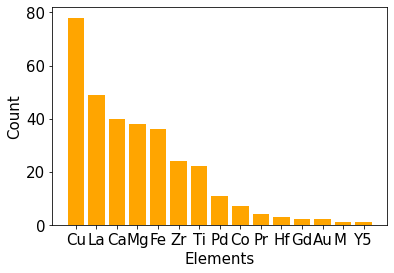

In [ ]:
element_counts = df['element'].value_counts().to_dict()
# my_colors = list('rgbkymc')  #red, green, blue, black, etc.

plt.bar(element_counts.keys(),element_counts.values(),color = 'orange')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.show()

In [ ]:
import seaborn as sns
d = df[['hmix','smix','d','e']]
d.columns = ['$∆H_{mix}$','$∆S_{mix}$','∆d','∆e']
ax = plt.figure(figsize=(10,8))
sns.heatmap(d.corr(),annot=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
features  = ['hmix','smix','d','e']
label = 'dmax'
X = df[features]
Y = df[label]
x_train,x_test,y_train,y_test = df[features].values[:287],df[features].values[287:],df[label][:287],df[label][287:]

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)



```
best params --> maxdepth=100, n_est = 10
```



In [ ]:
def r_squared(test,actual):
  rss = actual-(sum(actual)/len(actual))
  rss_sum = sum([x**2 for x in rss])
  tss = actual-test
  
  tss_sum = sum([x**2 for x in tss])

  rsquare = 1-(tss_sum/rss_sum)
  return rsquare


In [ ]:
def mse(test,act):
  dum = act-test
  dum = [x**2 for x in dum]
  # dum = sum(dum)
  mse = sum(dum)/len(dum)

  return mse

In [ ]:
# pip install tensorflow==2.2

In [ ]:
import tensorflow as tf
from keras import Sequential
import keras.backend as K
import os
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization



In [ ]:
model = Sequential()
model.add(Dense(32,input_shape=(4,),activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

In [ ]:
# checkpoint_path = "opt_dmax1.h5"
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mse', verbose=1,save_best_only=True, mode='min')
# callback = EarlyStopping(monitor='val_mse',min_delta=0.000001,patience=250,mode='auto',)
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mse'])

In [ ]:
print(x_test.shape,y_test.shape)

(31, 4) (31,)


In [ ]:
history = model.fit(x_train_scaled,y_train,epochs=2000,validation_data=(x_test_scaled,y_test),verbose=1)

Epoch 1/2000
9/9 [==============================] - 0s 17ms/step - loss: 32.5985 - mse: 32.5985 - val_loss: 28.4569 - val_mse: 28.4569
Epoch 2/2000
9/9 [==============================] - 0s 4ms/step - loss: 17.0485 - mse: 17.0485 - val_loss: 18.2148 - val_mse: 18.2148
Epoch 3/2000
9/9 [==============================] - 0s 3ms/step - loss: 13.0836 - mse: 13.0836 - val_loss: 19.0002 - val_mse: 19.0002
Epoch 4/2000
9/9 [==============================] - 0s 3ms/step - loss: 12.9844 - mse: 12.9844 - val_loss: 17.4598 - val_mse: 17.4598
Epoch 5/2000
9/9 [==============================] - 0s 4ms/step - loss: 12.0225 - mse: 12.0225 - val_loss: 17.2804 - val_mse: 17.2804
Epoch 6/2000
9/9 [==============================] - 0s 3ms/step - loss: 11.7423 - mse: 11.7423 - val_loss: 16.9580 - val_mse: 16.9580
Epoch 7/2000
9/9 [==============================] - 0s 3ms/step - loss: 11.6003 - mse: 11.6003 - val_loss: 16.5671 - val_mse: 16.5671
Epoch 8/2000
9/9 [==============================] - 0s 4ms/st

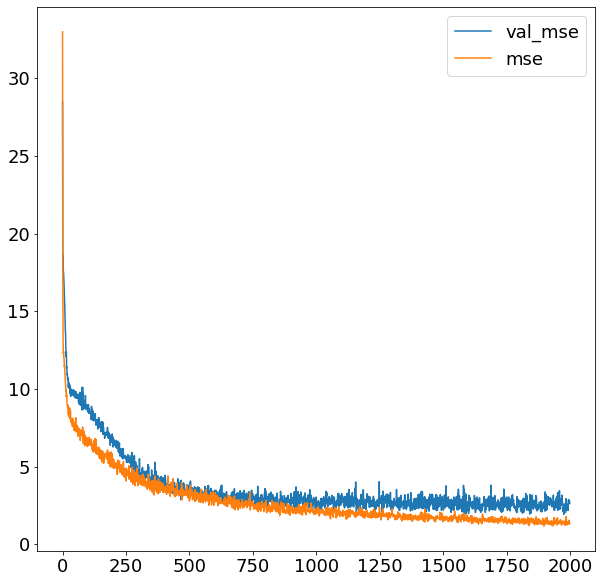

In [ ]:
hist = history.history

val_mse = hist['val_mse']
mse = hist['mse']

plt.figure(figsize = (10,10))
plt.plot(list(range(len(val_mse))),val_mse,label='val_mse')
plt.plot(list(range(len(mse))),mse,label='mse')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(x_test_scaled).ravel()
print(mse(pred,y_test))
print(r_squared(pred,y_test))

2.6222662098078935
0.8513494866464896


In [ ]:
tpred = model.predict(x_train_scaled).ravel()
print(mse(tpred,y_train))
print(r_squared(tpred,y_train))

0.8503340641770926
0.9299437741814951


In [ ]:
# opt_model = tf.keras.models.load_model('weighted_3.4.h5')

In [ ]:
model.save('norm_final.h5')

In [ ]:
print(len(pred))
print(len(y_test))
for i in range(len(y_test)):
  print(str(pred[i])+'      '+str(y_test[i])) 

31
31
7.6769786      8.0
3.8129456      4.0
4.1629333      4.0
3.6546013      5.0
1.5539267      1.5
10.258758      15.0
2.8345468      3.0
1.5233381      1.5
4.0601535      2.5
7.2977223      8.0
2.3557715      2.5
1.7519      1.5
1.9703496      2.0
2.677458      2.0
5.609652      6.0
2.9874387      5.0
4.569312      3.0
10.260326      9.0
2.0210268      2.0
11.709486      12.0
4.818968      5.0
5.3728857      5.0
1.9165828      2.5
4.18355      4.0
1.4514577      3.0
1.2341607      4.0
4.829215      2.0
6.8885655      8.0
3.9842467      6.0
8.284307      10.0
15.739297      20.0


In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
compare = {}

compare['ANN'] = [0.914,0.8684732389560386]
compare['Random Forest'] = [0.8687237695472815,0.7097523947197606]


In [ ]:
compare = {}

compare['ANN'] = [1.02,2.32]
compare['Random Forest'] = [1.593,5.12]

In [ ]:
compare_df = pd.DataFrame(compare.values(),columns=['Training','Testing'],index=compare.keys())
print(compare_df)

               Training  Testing
ANN               1.020     2.32
Random Forest     1.593     5.12


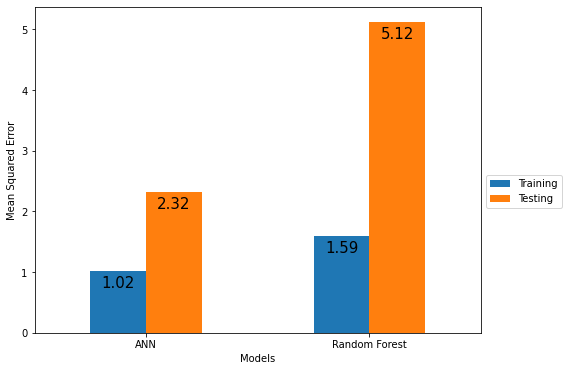

In [ ]:
ax = compare_df.plot.bar(figsize=(8,6), rot=0)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# plt.title('Models Comparison')
plt.xlabel('Models')
plt.legend(loc = 'best',bbox_to_anchor=(1.0,0.5))
plt.ylabel('Mean Squared Error')
# plt.ylabel('R-Squared Score')
plt.show()

In [ ]:
true = [8,   4,   4,   5,   1.5, 15,   3,   1.5,  2.5,  8,   2.5,  1.5,  2,   2, 6,   5,   3,   9,   2,  12,   5,   5,   2.5 ,  4,   3,   4,   2,   8, 6,  10 , 20]
ann_pred  = [ 7.2778378 , 3.887807 ,  4.53403 ,   2.3298492 , 2.9470367 , 11.613099,  3.2891686 , 1.7070849 , 3.9815078 , 8.582192 ,  3.3968406 , 1.5455558 , 1.6606126 , 2.1564665 , 5.0785933 , 4.0048213 , 4.4652877 , 9.250256 , 1.8633573 , 10.291681  , 4.2429886 , 5.4773803 , 1.8283648 , 3.3345852 , 1.4620137 , 1.9806273 , 4.9523697 , 6.549442 ,  4.570032 ,  8.763082 ,15.842346]
rf_pred = [ 9.4375  ,    3.81419102 , 4.79056039 , 5.09517045 , 2.46875  ,  11.82153799,  3.28514194 , 4.578125 ,   3.93008242 , 8.78125 ,    2.86049107 , 2.50178571,  2.09375  ,   3.375  ,     7.17329545 , 5.66776392 , 6.41181577 , 9.70833333,  2.25    ,    9.625   ,    4.47383242 , 5.59375    , 2.28125    , 5.77844703,  2.21875  ,   2.50402462,  7.72778799 , 5.11321023 , 5.640625   , 9.42612695, 12.14208896]

In [ ]:
pred_df = pd.DataFrame(data = {'true':true,'Ann':ann_pred,'rf':rf_pred})
pred_df.head()

,true,Ann,rf
0,8.0,7.277838,9.437500
1,4.0,3.887807,3.814191
2,4.0,4.534030,4.790560
3,5.0,2.329849,5.095170
4,1.5,2.947037,2.468750


In [ ]:
pred_df.to_csv('preds.csv')

In [ ]:
import seaborn as sns
from scipy import stats

In [ ]:
plt.rcParams.update({'font.size': 20})

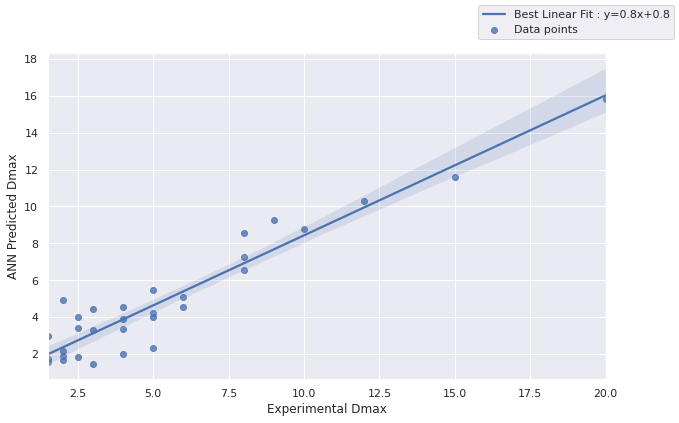

In [ ]:
sns.set_theme(color_codes=True)
fig = plt.figure(figsize=(10,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(pred_df['true'],pred_df['Ann'])
sns.regplot(x = 'true',y = 'Ann',data = pred_df,line_kws={'label':"Best Linear Fit : " + "y={0:.1f}x+{1:.1f}".format(slope,intercept)},label='Data points')
plt.xlabel('Experimental Dmax')
plt.ylabel('ANN Predicted Dmax')
fig.legend()
plt.show()
# fig.savefig('temp.png', transparent=True)

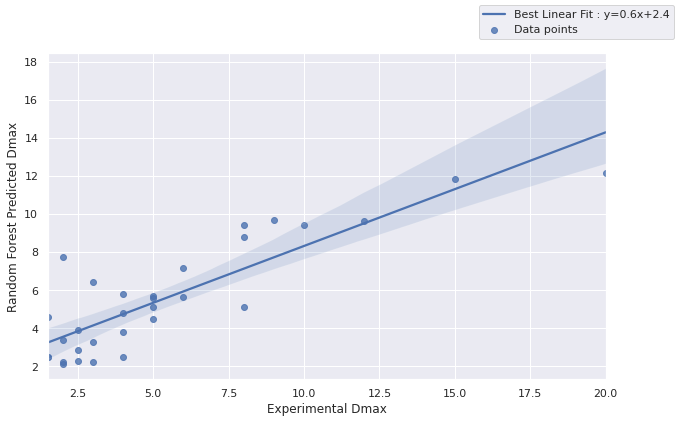

In [ ]:
sns.set_theme(color_codes=True)
fig = plt.figure(figsize=(10,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(pred_df['true'],pred_df['rf'])
sns.regplot(x = 'true',y = 'rf',data = pred_df,line_kws={'label':"Best Linear Fit : " + "y={0:.1f}x+{1:.1f}".format(slope,intercept)},label='Data points')
plt.xlabel('Experimental Dmax')
plt.ylabel('Random Forest Predicted Dmax')
fig.legend()
plt.show()

In [ ]:
comp = pd.DataFrame({'Predicted':pred,'Actual':y_test})
comp.head()

,Predicted,Actual
0,7.676979,8.0
1,3.812946,4.0
2,4.162933,4.0
3,3.654601,5.0
4,1.553927,1.5


In [ ]:
comp.to_excel('comparision.xlsx')

In [ ]:
print(r_squared(pred,y_test))

0.8606788728409542


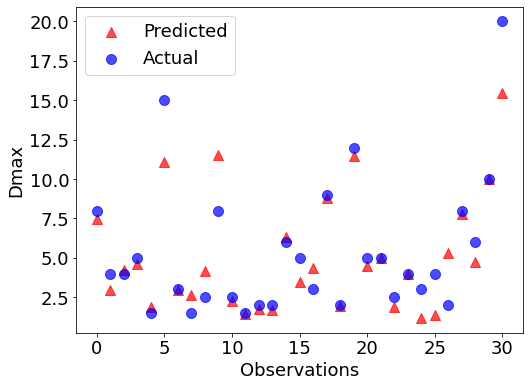

In [ ]:
ax = plt.figure(figsize=(8,6))
plt.scatter(list(range(len(pred))),pred,label='Predicted',c = 'red',alpha=0.7,marker='^',s=100)
plt.scatter(list(range(len(pred))),y_test,label = 'Actual',c = 'blue',alpha=0.7,s=100)
plt.ylabel('Dmax')
plt.xlabel('Observations')
plt.legend()
plt.show()

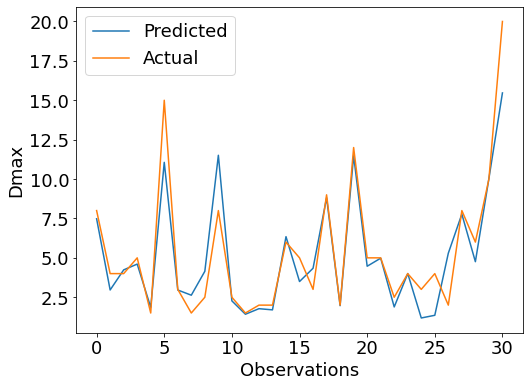

In [ ]:
ax = plt.figure(figsize=(8,6))
plt.plot(pred,label='Predicted')
plt.plot(y_test,label = 'Actual')
plt.ylabel('Dmax')
plt.xlabel('Observations')
plt.legend()
plt.show()

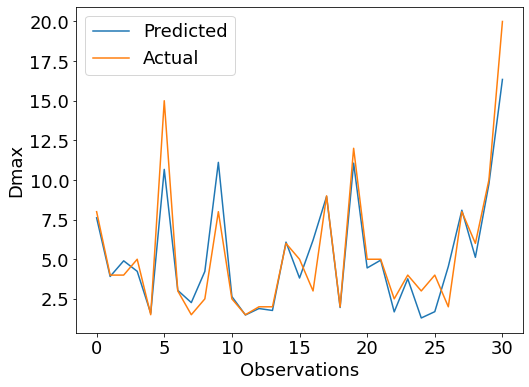

In [ ]:
ax = plt.figure(figsize=(8,6))
plt.plot(pred,label='Predicted')
plt.plot(y_test,label = 'Actual')
plt.ylabel('Dmax')
plt.xlabel('Observations')
plt.legend()
plt.show()

Analysis on Rc

In [ ]:
src = [46.1, 30.0, 178.0, 50.0, 1.5, 67.5, 22.5, 72.3, 37.5, 18.8, 100.0, 125.0]
sdmax = [2.8, 3.5, 1.5, 4.0, 16.0, 3.0, 5.0, 3.0, 2.0, 9.0, 1.5, 2.0]
name = ['Mg75Ni15Nd10', 'Mg65Ni20Nd15', 'Mg70Ni15Nd15', 'Mg65Cu25Y10', 'Zr65Al7.5Cu17.5Ni10', 'La55Al25Ni20', 'La55Al25Ni10Cu10', 'La55Al25Cu20', 'La66Al14Cu20', 'La55Al25Ni5Cu10Co5', 'Pd77.5Cu6Si16.5', 'Pd77Cu6Si17']

In [ ]:
cal_rc = []
for x in sdmax:
  zc = math.log10(x)
  res = 10**(3.28-(2.812*zc))
  cal_rc.append(res)

In [ ]:
rcdf = pd.DataFrame({'Dmax':sdmax,'Rc:Actual':src,'Rc:Calculated':cal_rc})
rcdf.head()

,Dmax,Rc:Actual,Rc:Calculated
0,2.8,46.1,105.339588
1,3.5,30.0,56.244578
2,1.5,178.0,609.300283
3,4.0,50.0,38.637348
4,16.0,1.5,0.783456


In [ ]:
rcdf.to_excel('RcAnalysis.xlsx')

Text(0, 0.5, 'Rc')

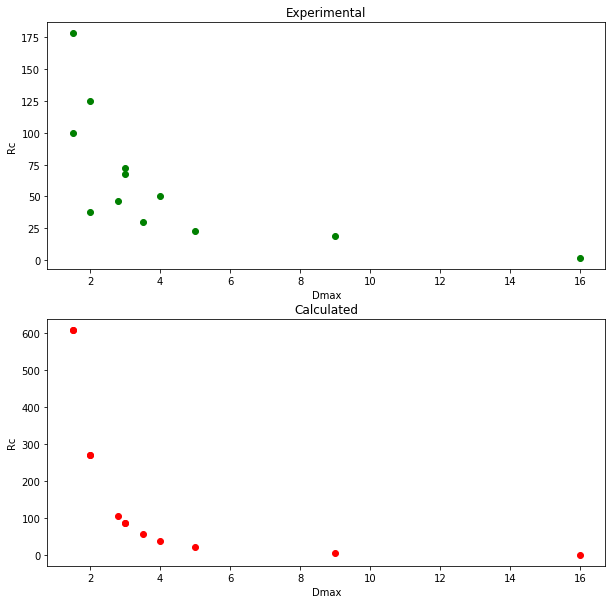

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
ax.scatter(sdmax,src,c='green')
plt.xlabel('Dmax')
plt.ylabel('Rc')
plt.title('Experimental')

ax1 = fig.add_subplot(2,1,2)
plt.title('Calculated')
ax1.scatter(sdmax,cal_rc,c='red')
plt.xlabel('Dmax')
plt.ylabel('Rc')